# Integrantes
* ### David Herrera
* ### Estid Lozano
* ### Nicolás González

In [1]:
# Imports
from numbers import Number
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from smlutil import *
import itertools
from collections import Counter

# Exercise 1

**1.1** Consider a binary classification problem. Prove that the entropy of the data is 0 if there
are only samples of one class and that it is maximal if there is exactly the same number
of instances for both classes in the data. What is the valued of the entropy in that case?
Hint: Compute the derivative of the entropy and show that it is 0 for a class probability
of 0.5.

Consider the two extreme situations (region is pure, and both classes has a $ \frac{1}{k} $ probability)

If there's only samples of one class:

$ H(D) = -\sum_{i=1}^{k} P(c_i|D) \cdot log_2 P(c_i|D) $

$ H(D) = -\sum_{i=1}^{1} (1) log_2(1) $

$ H(D) = -(1)(0) = 0 $

If there's same number of instances:

$ H(D) = -\sum_{i=1}^{k} P(c_i|D) \cdot log_2 P(c_i|D) $

$ H(D) = -k \cdot (\frac{1}{k} \cdot log_2 (\frac{1}{k})) $

$ H(D) = -1 \cdot (-log_2(k)) = log_2(k) $

Where 0 and $ log_2(k) are the minimum and maximum values that entropy can take, respectively.

**1.2.** Consider a k-class classification problem. Determine analytically the exact range of
values the Gini-Index can take.


Starting from the Gini's formula:

$ G(D) = 1 - \sum_{i=1}^{k} P(c_i|D)^2 $

If the region is pure, then:

$ G(D) = 1 - \sum_{i=1}^{1} 1^2 = 0 $

If both classes have the same number of instances:

$ G(D) = 1 - \sum_{i=1}^{k} (\frac{1}{k})^2 = 0 $

$ G(D) = 1 - \frac{k}{k^2} $

$ G(D) = 1 - \frac{1}{k} = \frac{k - 1}{k} $

Where 0 and $ \frac{k - 1}{k} $ are the minimum and maximum values that Gini can take, respectively.

**1.3** Consider a binary classification problem. Now for values of P(c1|D) E [0; 1], create plots
for the entropy, the Gini-Index, and the CART-index.

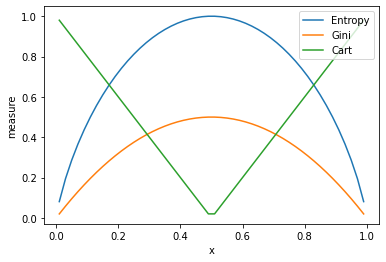

In [45]:
X = np.linspace(0.01, 0.99)
plt.plot(X, [-(x * math.log2(x) + (1 - x) * math.log2(1 - x)) for x in X], label = "Entropy")
plt.plot(X, [1 - (math.pow(x, 2) + math.pow(1 - x, 2)) for x in X], label = "Gini")
plt.plot(X, [abs(2 * x - 1) for x in X], label = "Cart")
plt.xlabel('x')
plt.ylabel('measure')
plt.legend()

Now suppose that a dataset exhibits the maximum entropy. Further suppose that we
have a split point that will split the dataset into exactly two equally large parts, i.e.,
|DY| = |DN| = |D|=2. Now create a 3D surface plot in which you show the information
gain for different combinations of values of H(DY) and H(DN).

**1.4.** A very simple rule-based learner is the so called Majority classifier, which always, without
looking at the instance values, predicts the class that was most frequent in the training
data.
Show that the decision tree algorithm can be configured so that it behaves exactly like
the majority classifier.

The decision tree algorithm can be configured to behaves like the majority classifier by setting π (purity threshold) to zero or setting η (the minimum instances count per region) to n (|D|); that's because the decision tree algorithm does not any partition, and always predicts the most common class.

# Exercise 2

**1.1.** Implement the decision tree algorithm for both numerical and categorical attributes. For
categorical attribute, you can assume that jV j = 1. As in the pseudo-code, treat the
function Gain as a (functional) parameter of your algorithm.

In [ ]:
class DecisionTree:
    def __init__(self, gain, _n=5, _pi=0.95):
        self.gain = gain
        self._n = _n
        self._pi = _pi
        self.tree = {}
        self.data = {}
        
    def getName(self):
        return "DecisionTree"
  
    def train(self, X, Y, parent=None):
        if not self.data:
            self.data={"X":X,"Y":Y}
        if(parent is None):
            parent = self.tree
        n = len(X)
        ni = dict(Counter(Y))
        ni_n = {k: v/n for k, v in ni.items()}
        purity = max(ni_n.values())
        if n < self._n or purity >= self._pi:
            c_ = max(ni_n, key=ni_n.get)
            parent["max"] = c_
            parent["table"] = ni
            return
        splitPoint, bestScore = None, 0
        for attrX in range(len(X[0])):
            if isinstance(X[0][attrX], Number):
                v, score = self.evaluateNumericAttribute(X, Y, attrX)
                if score > bestScore:
                    splitPoint, bestScore = (attrX, v), score
            else:
                v, score = self.evaluateCategoricalAttribute(X, Y, attrX)
                if score > bestScore:
                    splitPoint, bestScore = (attrX, v), score
        if splitPoint is not None:
            if isinstance(X[0][splitPoint[0]], Number):
                Dy = [indx for indx, x in enumerate(X) if x[splitPoint[0]] <= splitPoint[1]]
                Dn = [indx for indx, x in enumerate(X) if not x[splitPoint[0]] <= splitPoint[1]]
            else:
                Dy = [indx for indx, x in enumerate(X) if x[splitPoint[0]] in splitPoint[1]]
                Dn = [indx for indx, x in enumerate(X) if  x[splitPoint[0]] not in splitPoint[1]]

            parent[str(splitPoint)] = {"Dy": {}, "Dn": {}}
            # if(len(Dy)>0):
            self.train(X[Dy], Y[Dy], parent[str(splitPoint)]["Dy"])
            # if(len(Dn)>0):
            self.train(X[Dn], Y[Dn], parent[str(splitPoint)]["Dn"])
        else:
            c_ = max(ni_n, key=ni_n.get)
            parent["max"] = c_
            parent["table"] = ni
            return
    
    def evaluateNumericAttribute(self, X, Y, attrX):
        X = X[:, attrX]
        argS = np.argsort(X)
        X = X[argS]
        Y = Y[argS]
        M = set()
        classes = np.unique(Y)
        ni = {k: 0 for k in classes}
        Nvi = {}
        for j in range(len(X)-1):
            ni[Y[j]] += 1
            if (X[j+1] != X[j]).any():
                v = (X[j+1]+X[j])/2
                M.add(v)
                for i in classes:
                    if not str(v) in Nvi:
                        Nvi[str(v)] = {}
                    Nvi[str(v)][i] = len([x for x, y in zip(X, Y) if x <= v and y == i])
        ni[Y[-1]] += 1
        _v, bestScore = None, 0
        PciD = {k:v/len(X) for k,v in ni.items()}
        PciDy = {}
        ny = 0
        PciDn = {}
        nn = 0
        for v in M:
            ny = 0
            for i in classes:
                ny += Nvi[str(v)][i]
                PciDy[i] = Nvi[str(v)][i] / sum(Nvi[str(v)].values())
                PciDn[i] = (ni[i]-Nvi[str(v)][i])/sum([ni[j]-Nvi[str(v)][j]for j in Nvi[str(v)].keys()])
            nn = len(X)-ny
            score = self.gain.evaluate(PciD,len(X),ny,nn,PciDy,PciDn,classes)
            if score > bestScore:
                _v = v
                bestScore = score
        return _v, bestScore
    def evaluateCategoricalAttribute(self, X, Y, attrX):
        X = X[:, attrX]
        classes = np.unique(Y)
        domX = np.unique(X)
        nvi = {}
        ni = {}
        for cla in classes:
            ni[cla]=0
            nvi[cla] = {}
            for v in domX:
                nvi[cla][v]=0
        for x,y in zip(X,Y):
            ni[y]+=1
            nvi[y][x]+=1

        PciD = {k:v/len(X) for k,v in ni.items()}
        PciDy = {}
        PciDn = {}
        ny = 0
        nn = 0
        _v,bestScore=None,0
        for V in list(itertools.combinations(domX, 1)):
            for i in classes:
                ny = sum([1 for v in X if v in V])
                nn = sum([1 for v in X if v not in V])
                try:
                    PciDy[i] = sum([nvi[i][v] for v in domX if v in V ])/ sum([sum([nvi[j][v]
                        for v in domX if v in V]) for j in classes])
                except:
                    PciDy[i] = 0
                try:
                    PciDn[i] = sum([nvi[i][v] for v in domX if v not in V ])/ sum([sum([nvi[j][v]
                        for v in domX if v not in V]) for j in classes])
                except:
                    PciDn[i] = 0
            score = self.gain.evaluate(PciD,len(X),ny,nn,PciDy,PciDn,classes)
            if score>bestScore:
                _v = V
                bestScore=score
        return _v,bestScore

    def printTree(self):
        self.formatData(self.tree)
    def formatData(self, t, s=0):
        if not isinstance(t, dict) and not isinstance(t, list):
            print("| "*s+str(t))
        else:
            for key in t:
                print("| "*s+str(key))
                if not isinstance(t, list):
                    self.formatData(t[key], s+1)
    
    def predict(self, X):
        res= []
        for x in X:
            res.append(self.recursivePredict(self.tree,x))
        return res
    def recursivePredict(self, t,x):
        for key in t:
            if not isinstance(t, list):
                if(key=="max"):
                    return t[key]
                condition = eval(key)
                attr=condition[0]
                val=condition[1]
                if isinstance(x[attr], Number):
                    if(x[attr]<=val):
                        return self.recursivePredict(t[key]["Dy"],x)
                    else:
                        return  self.recursivePredict(t[key]["Dn"],x)
                else:
                    if(x[attr] in val):
                        return self.recursivePredict(t[key]["Dy"],x)
                    else:
                        return  self.recursivePredict(t[key]["Dn"],x)
    
    def plotTree(self,fig=None,ax=None):
        classes =list(np.unique(self.data["Y"]))
        cm = plt.get_cmap('gist_rainbow')
        colors = [cm(1.*i/len(classes)) for i in range(len(classes))]
        if fig == None:
            fig, ax = plt.subplots(1,1,figsize=(10,7))
        for x,y in zip(self.data["X"],self.data["Y"]):
            ax.scatter(x[0], x[1],color=colors[classes.index(y)])
        y_min, y_max = ax.get_ylim()
        x_min, x_max = ax.get_xlim()
        self.getLinesRecursive(self.tree,ax,y_min, y_max,x_min, x_max)
    def getLinesRecursive(self, t,ax,y_min, y_max,x_min, x_max):
        for key in t:
            if not isinstance(t, list):
                if(key=="max"):
                    return 
                condition = eval(key)
                attr=condition[0]
                val=condition[1]
                saveX_max=x_max
                savey_max=y_max
                if(attr==0):
                    ax.plot((val,val), (y_min, y_max), 'k-')
                    x_max=val
                else:
                    ax.plot((x_min, x_max), (val,val), 'k-')
                    y_max=val

                self.getLinesRecursive(t[key]["Dy"],ax,y_min, y_max,x_min, x_max)
                x_max=saveX_max
                y_max=savey_max
                if(attr==0):
                    x_min=val
                else:
                    y_min=val
                self.getLinesRecursive(t[key]["Dn"],ax,y_min, y_max,x_min, x_max)


class informationGain:
    def evaluate(self,PciD,n, ny,nn,PciDy,PciDn,classes):
        return (-sum([PciD[i]*math.log(0.00000001 if PciD[i] == 0 else PciD[i], 2) for i in classes])) -((ny/(n))*(-sum([PciDy[i]*math.log(0.00000001 if PciDy[i] == 0 else PciDy[i], 2) for i in classes]))+(nn/(n))*(-sum([PciDn[i]*math.log(0.00000001 if PciDn[i] == 0 else PciDn[i], 2) for i in classes])))
class giniIndex:
    def evaluate(self,PciD,n, ny,nn,PciDy,PciDn,classes):
        return (1-sum([PciD[i]**2 for i in classes]))-((ny/(n))*(1-sum([PciDy[i]**2 for i in classes]))+(nn/(n))*(1-sum([PciDn[i]**2 for i in classes])))
class cart:
    def evaluate(self,PciD,n, ny,nn,PciDy,PciDn,classes):
        return (2*(ny/(n))*(nn/(n))* sum([abs(PciDy[i]-PciDn[i]) for i in classes]))


**1.2.** Create a function that can visualize the segmentation produced by a decision tree. Plot
this segmentation for the iris dataset for the three different split point criteria (information
gain, gini-index, and CART).

In [ ]:
# Read dataset
df = pd.read_csv('iris.csv')
# get first 2 rows
X = df.iloc[:, :2].to_numpy()
# get labels
Y = df.iloc[:, -1].to_numpy()


model = DecisionTree(informationGain())
model.train(X, Y)
model.plotTree()

model = DecisionTree(giniIndex())
model.train(X, Y)
model.plotTree()

model = DecisionTree(cart())
model.train(X, Y)
model.plotTree()

# book example
Y = np.where(Y != "setosa", "others", Y)
model = DecisionTree(informationGain())
model.train(X, Y)
model.plotTree()
print(model.tree)

model = DecisionTree(giniIndex())
model.train(X, Y)
model.plotTree()
print(model.tree)

model = DecisionTree(cart())
model.train(X, Y)
model.plotTree()
print(model.tree)


**1.3.** Consider values of _n E {1, 2, 5, 10} and _pi E {1.0, 0.9, 0.8, 0.5}. Create three 4 x 4 plot grids, one for each split criterion (information gain, gini-index, and CART) and each grid representing the parameter combinations of _n and _pi.
In each cell, show the learning curves of the decision tree classifier on the breast cancer data using the respective values for _n and _pi. Do you observa any effect? For which case do you obtain the best results.

In [ ]:
df = pd.read_csv('breast-cancer.csv').to_numpy()
X = df[:, :2]
Y = df[:, -1]
_n= [1, 2, 5, 10]
_p= [1.0, 0.9, 0.8, 0.5]
axInd=[[0,0],[0,1],[1,0],[1,1]]
splits= [informationGain(),giniIndex(),cart()]
for sp in splits:
    fig, ax = plt.subplots(2,2,figsize=(20,14))
    fig.suptitle(type(sp).__name__, fontsize=16)
    for n,pi,ind in zip(_n,_p,axInd):
        ax[ind[0]][ind[1]].set_title('n: '+str(n)+" pi: "+str(pi))
        model = DecisionTree(sp,n,pi)
        model.train(X, Y)
        plot_learning_curves(DecisionTree(informationGain()),X,Y,ax[ind[0]][ind[1]])
    
